# UNet

En este notebook se implementa la arquitectura UNet para la segmentación de imágenes.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

In [1]:
# importamos las librerias necesarias
import os 
from pathlib import Path
from PIL import Image
import numpy as np

path = Path('./Dataset/Moneyv6icoco-segmentation/') # Path del dataset
images_train = [path/'train'/i for i in os.listdir(path/'train')] # path de las imagenes de entrenamiento
mascaras_train = [path/'trainmasks'/i for i in os.listdir(path/'trainmasks')] # path de las mascaras de entrenamiento
images_test = [path/'test'/i for i in os.listdir(path/'test')] # path de las imagenes de test
mascaras_test = [path/'testmasks'/i for i in os.listdir(path/'testmasks')] # path de las mascaras de test

La función `cargar_imagenes_y_mascaras` carga las imágenes y las máscaras de la carpeta `data` y las devuelve en forma de `numpy array`. Esto con el fin de hacer algo más después, hiremos viendo el por qué.

In [2]:
# Función para cargar imágenes y máscaras como arrays de numpy
def cargar_imagenes_y_mascaras(img_paths, mask_paths):
    imagenes = []
    mascaras = []
    for img_path, mask_path in zip(img_paths, mask_paths):
        # Cargar imágenes y máscaras con Pillow
        imagen = Image.open(img_path)
        mascara = Image.open(mask_path)
        # convertir a float la imagen
        imagen = np.array(imagen)/255.
        # convertir a float la mascara
        mascara = np.array(mascara)/255.
        
        # Convertir imágenes y máscaras a arrays de numpy
        imagen_array = np.array(imagen)
        mascara_array = np.array(mascara)
        
        # Agregar arrays de numpy a las listas
        imagenes.append(imagen_array)
        mascaras.append(mascara_array)
    
    return np.array(imagenes), np.array(mascaras)

In [3]:
# Cargar imágenes y máscaras como arrays de numpy
imagenes_numpy, mascaras_numpy = cargar_imagenes_y_mascaras(images_test, mascaras_test)

# Verificar las formas de los arrays de numpy
print("Forma de las imágenes numpy:", imagenes_numpy.shape)
print("Forma de las máscaras numpy:", mascaras_numpy.shape)

Forma de las imágenes numpy: (120, 512, 512, 3)
Forma de las máscaras numpy: (120, 512, 512, 4)


Usamos las imagenes de test para hacer un ejercecio que haremos a continuación.

In [4]:
# cargamnos las imagenes y las mascaras
imgs = imagenes_numpy
masks = mascaras_numpy

In [5]:
# mostramos las dimensiones de las imagenes y las mascaras
imgs[0].shape, masks[0].shape

((512, 512, 3), (512, 512, 4))

Visualozamos las imagenes y las máscaras. Para ver que todo está bien y que las máscaras son correctas.

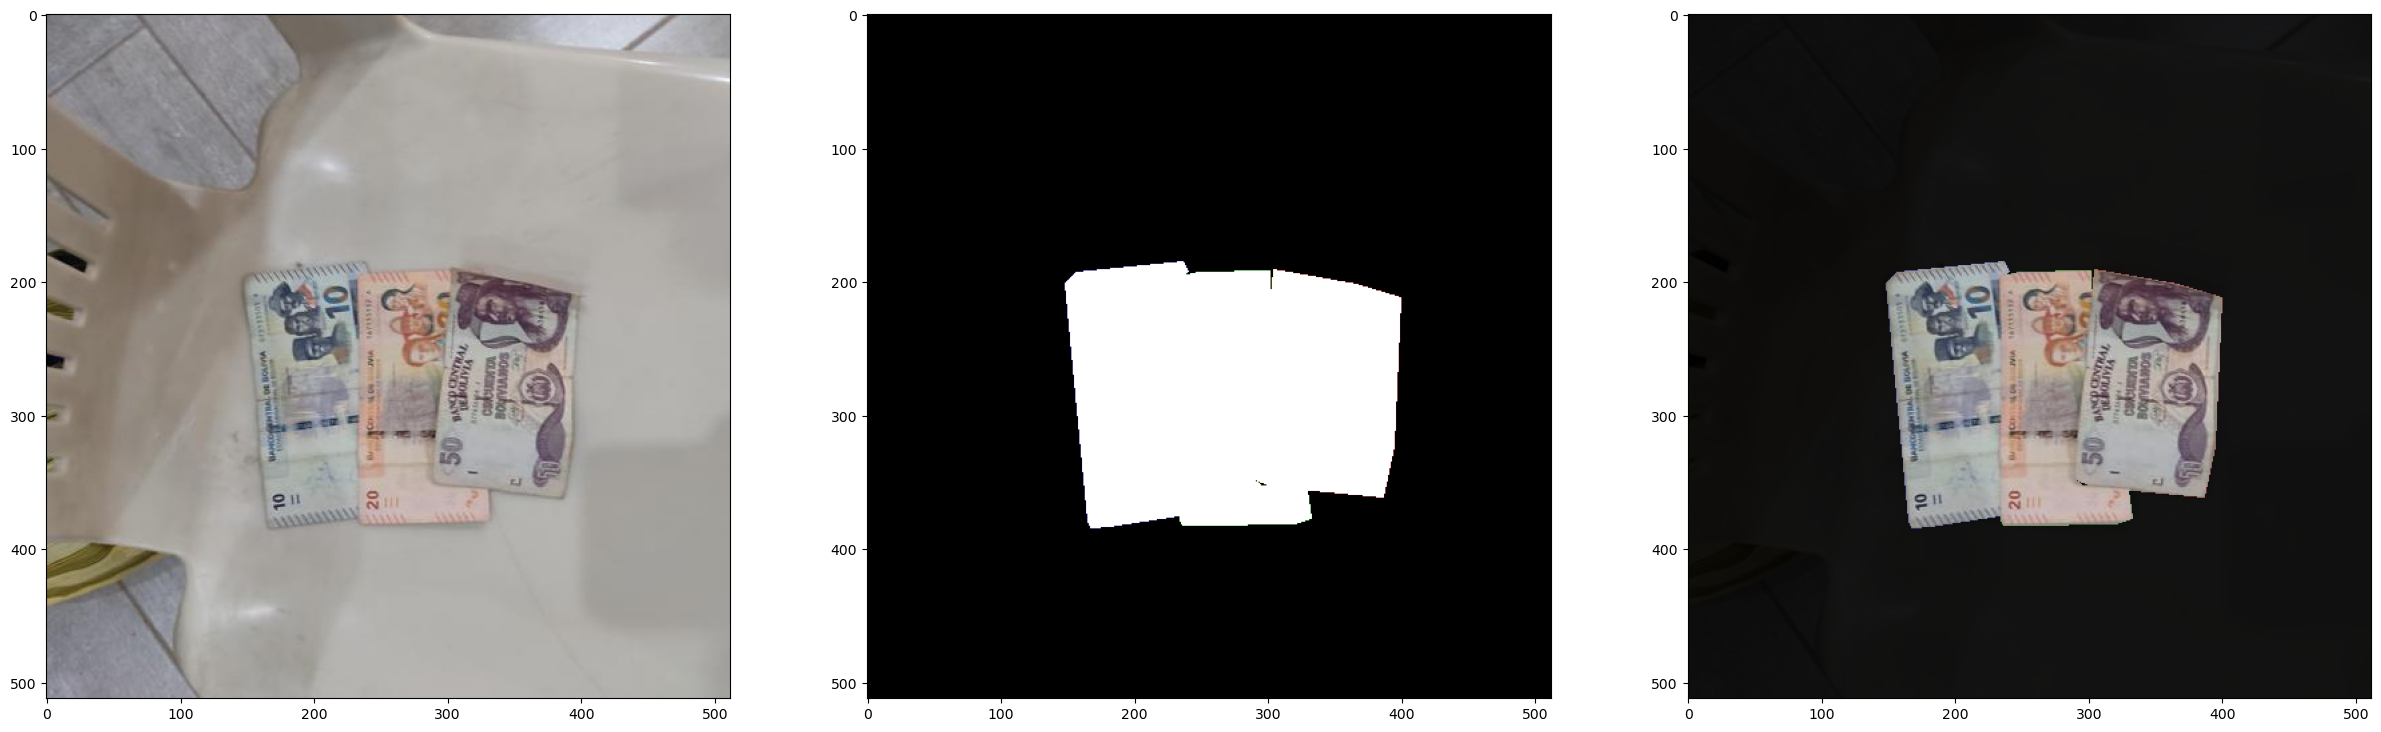

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random

#idx = random.randint(0, len(imgs)-1)
#print(idx)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ix = 99
img = imgs[ix]
mask = masks[ix]
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.9)
plt.show()

In [7]:
# verificamos la dimensión y el tipo de dato de las imagenes
img.shape, img.dtype, img.max(), img.min()

((512, 512, 3), dtype('float64'), 1.0, 0.0)

In [8]:
# verificamos la dimensión y el tipo de dato de las mascaras
mask.shape, mask.dtype, mask.max(), mask.min()

((512, 512, 4), dtype('float64'), 1.0, 0.0)

## Modelo UNet

Aquí implementaremos el modelo `UNet`. Este modelo es una arquitectura de red neuronal convolucional para la segmentación de imágenes. Fue desarrollada en 2015 por Olaf Ronneberger, Philipp Fischer y Thomas Brox en la Universidad de Friburgo y ganó la competencia ISBI de segmentación de células neuronales. El modelo UNet se basa en una arquitectura de red neuronal totalmente convolucional para realizar la segmentación de imágenes. Su arquitectura se basa en una red neuronal convolucional en forma de U, por lo que se le llama UNet.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

### UNet con ResNet18

Para solucionar el problema anteriormente que obtuvimos, usaremos la arquitectura `ResNet18` que nos permitirá mejorar la precisión del modelo y haciendo uso del transfer learning.

In [4]:
import torch.nn.functional as F
import torch
import torchvision

# convolucional 3x3 con batch normalization y relu
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

# clase decoder que recibe la salida de la capa anterior y la salida de la etapa
class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.Sequential(
                        torch.nn.Upsample(scale_factor=2, mode='bicubic'),
                        torch.nn.Conv2d(ci, co, kernel_size=1, stride=1)
                        )
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=4, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(weights='IMAGENET1K_V1')           
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = x.clone().detach()
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

Hacemos las pruebas para ver que todo está bien.

In [5]:
model = UNetResnet()
output = model(torch.randn((1,3,512,512)))
output.shape

torch.Size([1, 4, 512, 512])

### Hacemos el fit de una imagen

Haremos el fit de una imagen para ver que realmente esta funcionando el modelo. Para ello, usaremos la imagen `img` y la máscara `mask` de la función `cargar_imagenes_y_mascaras`.

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        X = X.float()  # Convertir X a tipo float
        y = y.float()  # Convertir y a tipo float
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

Preparamos la imagen y la máscara con la que vamos a trabajar.

In [12]:
img_tensor = torch.tensor(img).unsqueeze(0).permute(0, 3, 1, 2)
mask_tensor = torch.tensor(mask).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 4, 512, 512]))

In [14]:
# entrenamos el modelo con una imagen
fit(model, img_tensor, mask_tensor, epochs=50)

Epoch 1/50 loss 0.33157
Epoch 2/50 loss 0.39009
Epoch 3/50 loss 0.34676
Epoch 4/50 loss 0.33527
Epoch 5/50 loss 0.33192
Epoch 6/50 loss 0.32798
Epoch 7/50 loss 0.32410
Epoch 8/50 loss 0.32073
Epoch 9/50 loss 0.31809
Epoch 10/50 loss 0.31563
Epoch 11/50 loss 0.31301
Epoch 12/50 loss 0.31055
Epoch 13/50 loss 0.30824
Epoch 14/50 loss 0.30596
Epoch 15/50 loss 0.30366
Epoch 16/50 loss 0.30129
Epoch 17/50 loss 0.29910
Epoch 18/50 loss 0.29709
Epoch 19/50 loss 0.29505
Epoch 20/50 loss 0.29299
Epoch 21/50 loss 0.29094
Epoch 22/50 loss 0.28891
Epoch 23/50 loss 0.28691
Epoch 24/50 loss 0.28495
Epoch 25/50 loss 0.28304
Epoch 26/50 loss 0.28112
Epoch 27/50 loss 0.27920
Epoch 28/50 loss 0.27732
Epoch 29/50 loss 0.27548
Epoch 30/50 loss 0.27365
Epoch 31/50 loss 0.27180
Epoch 32/50 loss 0.26998
Epoch 33/50 loss 0.26818
Epoch 34/50 loss 0.26639
Epoch 35/50 loss 0.26461
Epoch 36/50 loss 0.26286
Epoch 37/50 loss 0.26111
Epoch 38/50 loss 0.25938
Epoch 39/50 loss 0.25767
Epoch 40/50 loss 0.25597
Epoch 41/

Vemos que el error es demasiado pequeño lo cual nos indica que el modelo está funcionando correctamente.


Pero ahora implementaremos una métrica para medir la precisión del modelo. Para ello, usaremos el `IoU` o `Intersection over Union` que es una métrica que se usa para medir la precisión de un modelo de segmentación. Para ello, usaremos la función `iou_metric` que nos calcula el `IoU` de la máscara predicha y la máscara real.

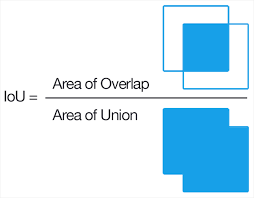

In [6]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        X = X.float()
        y = y.float()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [16]:
# entrenamos el modelo con una sola imagen
fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.23817 iou 0.98062
Epoch 2/100 loss 0.30839 iou 0.54932
Epoch 3/100 loss 0.27907 iou 0.58302
Epoch 4/100 loss 0.24306 iou 0.88888
Epoch 5/100 loss 0.22884 iou 0.93204
Epoch 6/100 loss 0.22270 iou 0.95370
Epoch 7/100 loss 0.21649 iou 0.95287
Epoch 8/100 loss 0.21032 iou 0.95824
Epoch 9/100 loss 0.20469 iou 0.96536
Epoch 10/100 loss 0.19943 iou 0.96888
Epoch 11/100 loss 0.19384 iou 0.97490
Epoch 12/100 loss 0.18907 iou 0.97877
Epoch 13/100 loss 0.18420 iou 0.98024
Epoch 14/100 loss 0.17954 iou 0.98021
Epoch 15/100 loss 0.17495 iou 0.97961
Epoch 16/100 loss 0.17072 iou 0.97863
Epoch 17/100 loss 0.16645 iou 0.97876
Epoch 18/100 loss 0.16236 iou 0.98153
Epoch 19/100 loss 0.15830 iou 0.98374
Epoch 20/100 loss 0.15442 iou 0.98573
Epoch 21/100 loss 0.15065 iou 0.98649
Epoch 22/100 loss 0.14695 iou 0.98603
Epoch 23/100 loss 0.14336 iou 0.98612
Epoch 24/100 loss 0.13992 iou 0.98646
Epoch 25/100 loss 0.13654 iou 0.98718
Epoch 26/100 loss 0.13322 iou 0.98882
Epoch 27/100 loss 0.1

Vemos que el modelo consigue una precision del `99.12%` lo cual nos indica que el modelo está funcionando correctamente ya que al hacer fit de una sola imagen hacemos overfitting y por eso la precisión es tan alta.

Motramos y predicimos la segmentación de la imagen `img` y la máscara `mask` con la hicimos overfitting al modelo.

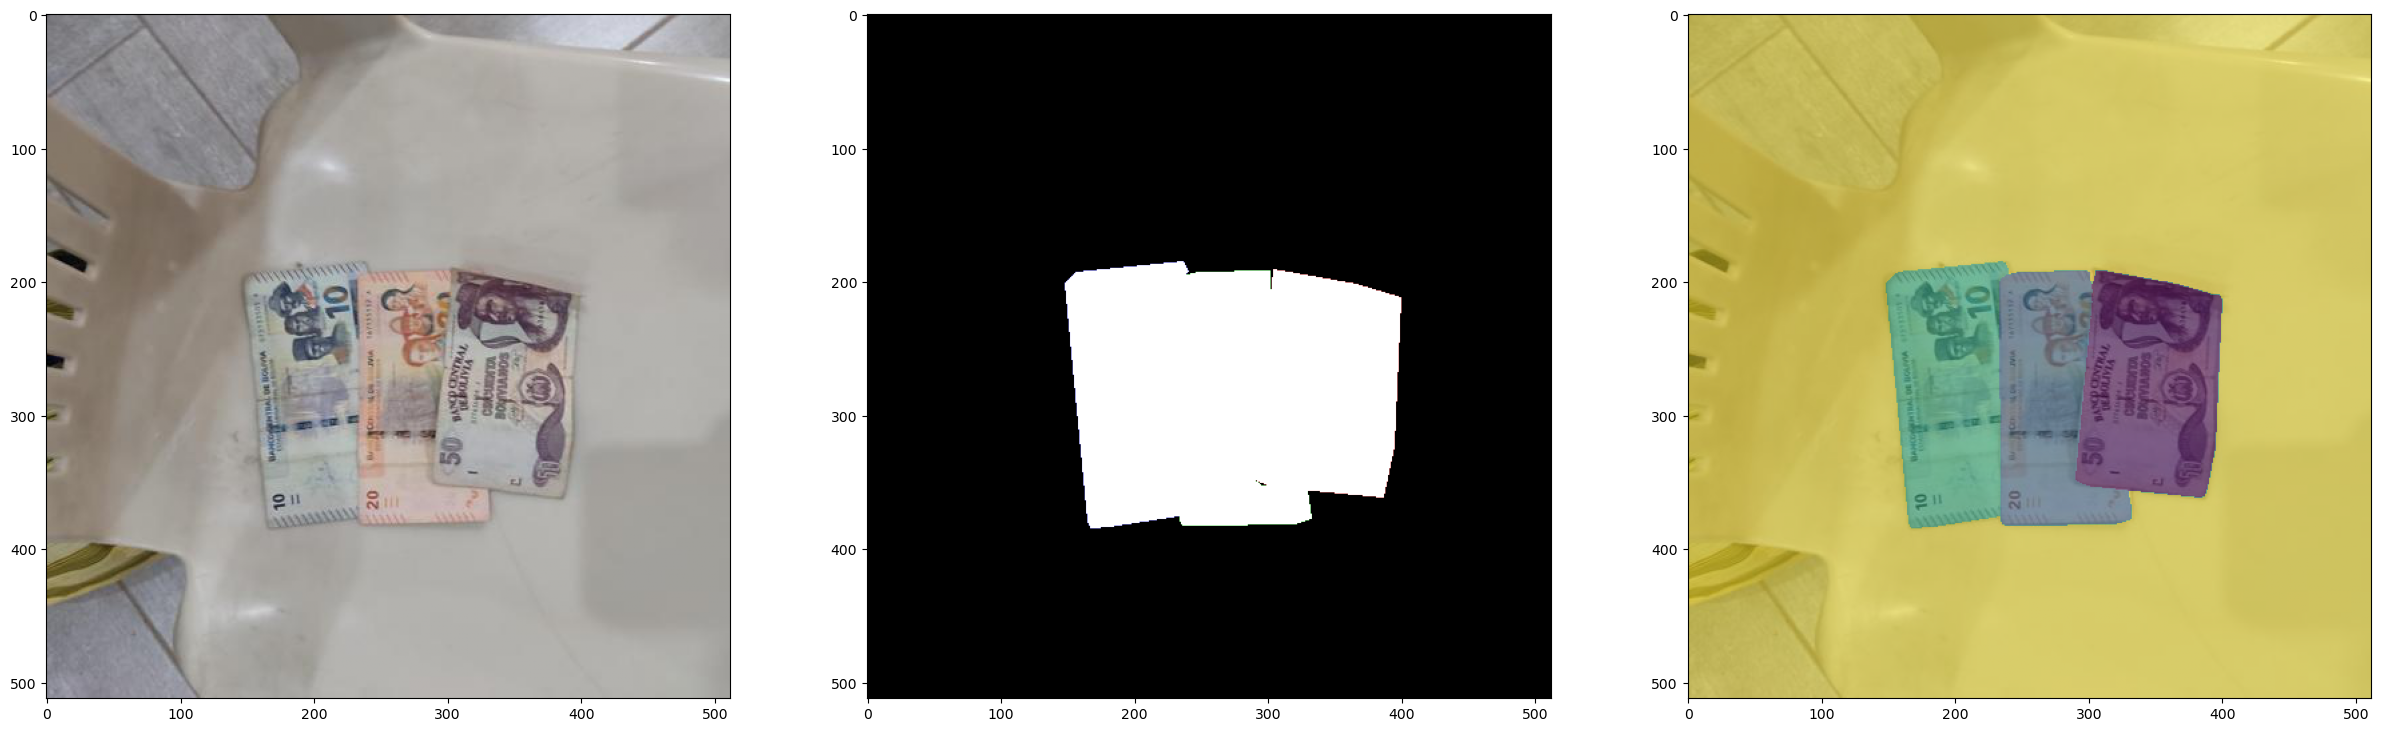

In [18]:
model.eval()
with torch.no_grad():
    img_tensor.float()
    output = model(img_tensor.to(device).float())[0]
    pred_mask = torch.argmax(output, axis=0) #type: ignore
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.5)
plt.show()

## Entrenamos con todo el dataset

Una vez tenido la certeza de que el modelo esta funcionando correctamente podemos seguir el siguiente paso, que es entrenar el modelo con todo el dataset para eso implementaremos clase `CustomDataset` que nos permitirá cargar el dataset completo y entrenar el modelo con el.

In [7]:
import torch
from torch.utils.data import Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        imagen = Image.open(self.img_paths[idx])
        mascara = Image.open(self.mask_paths[idx])

        # Convertir imágenes y máscaras a tensores de PyTorch
        X = torch.from_numpy(np.array(imagen) / 255.0).float().permute(2, 0, 1)
        y = torch.from_numpy(np.array(mascara) / 255.0).float().permute(2, 0, 1)

        if self.transform:
            # Aplicar transformación a las imágenes y máscaras
            X = self.transform(X)
            y = self.transform(y)

        return X, y

In [8]:
import torchvision.transforms as transforms

# aplicamos transformaciones a las imagenes
transform = transforms.Compose([
    #transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# creamos el dataset
dataset = {
    'train': CustomDataset(images_train, mascaras_train),
    'test': CustomDataset(images_test, mascaras_test)
}
# verificamos el tamaño del dataset
len(dataset['train']), len(dataset['test'])

(1302, 120)

In [9]:
# vemos la dimensiones de la imagenes y mascaras del dataset
dataset['train'][0][0].shape, dataset['train'][0][1].shape

(torch.Size([3, 512, 512]), torch.Size([4, 512, 512]))

In [10]:
# cargamos el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 3, 512, 512]), torch.Size([16, 4, 512, 512]))

Implementamos la función `fit` que nos permitirá entrenar el modelo con todo el dataset.

In [11]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
        bar = tqdm(dataloader['train'])
        train_loss, train_iou = [], []
        model.train()
        for imgs, masks in bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            y_hat = model(imgs)
            loss = criterion(y_hat, masks)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, masks)
            train_loss.append(loss.item())
            train_iou.append(ious)
            bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['iou'].append(np.mean(train_iou))
        bar = tqdm(dataloader['test'])
        test_loss, test_iou = [], []
        model.eval()
        
        with torch.no_grad():
            for imgs, masks in bar:
                imgs, masks = imgs.to(device), masks.to(device)
                y_hat = model(imgs)
                loss = criterion(y_hat, masks)
                ious = iou(y_hat, masks)
                test_loss.append(loss.item())
                test_iou.append(ious)
                bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_iou'].append(np.mean(test_iou))
        print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")

        torch.save(model.state_dict(), f"./models/UNetResNet_model_seg_v2_{epoch}.pt")
        
    return hist

#### Entrenamos el modelo

Entrenamos el modelo con todo el dataset. Para ello, usaremos la función `fit` que implementamos anteriormente. 

In [12]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=30)

test_loss 0.32673 test_iou 0.64832: 100%|██████████| 4/4 [00:17<00:00,  4.42s/it]



Epoch 1/30 loss 0.45308 iou 0.34527 test_loss 0.32673 test_iou 0.64832


test_loss 0.21252 test_iou 0.58859: 100%|██████████| 4/4 [00:19<00:00,  4.82s/it]



Epoch 2/30 loss 0.27723 iou 0.50482 test_loss 0.21252 test_iou 0.58859


test_loss 0.14555 test_iou 0.72156: 100%|██████████| 4/4 [00:17<00:00,  4.26s/it]



Epoch 3/30 loss 0.18512 iou 0.58002 test_loss 0.14555 test_iou 0.72156


test_loss 0.10536 test_iou 0.58243: 100%|██████████| 4/4 [00:18<00:00,  4.54s/it]



Epoch 4/30 loss 0.12950 iou 0.65654 test_loss 0.10536 test_iou 0.58243


test_loss 0.06928 test_iou 0.75522: 100%|██████████| 4/4 [00:18<00:00,  4.68s/it]



Epoch 5/30 loss 0.09374 iou 0.73766 test_loss 0.06928 test_iou 0.75522


test_loss 0.07289 test_iou 0.75036: 100%|██████████| 4/4 [00:18<00:00,  4.74s/it]



Epoch 6/30 loss 0.06888 iou 0.80047 test_loss 0.07289 test_iou 0.75036


test_loss 0.04282 test_iou 0.85514: 100%|██████████| 4/4 [00:18<00:00,  4.73s/it]



Epoch 7/30 loss 0.05157 iou 0.85504 test_loss 0.04282 test_iou 0.85514


test_loss 0.05607 test_iou 0.63836: 100%|██████████| 4/4 [00:18<00:00,  4.69s/it]



Epoch 8/30 loss 0.04420 iou 0.85130 test_loss 0.05607 test_iou 0.63836


test_loss 0.04566 test_iou 0.88101: 100%|██████████| 4/4 [00:18<00:00,  4.58s/it]



Epoch 9/30 loss 0.03613 iou 0.87497 test_loss 0.04566 test_iou 0.88101


test_loss 0.03546 test_iou 0.80857: 100%|██████████| 4/4 [00:18<00:00,  4.59s/it]



Epoch 10/30 loss 0.03513 iou 0.85423 test_loss 0.03546 test_iou 0.80857


test_loss 0.02632 test_iou 0.87329: 100%|██████████| 4/4 [00:18<00:00,  4.61s/it]



Epoch 11/30 loss 0.02637 iou 0.90149 test_loss 0.02632 test_iou 0.87329


test_loss 0.02961 test_iou 0.82514: 100%|██████████| 4/4 [00:18<00:00,  4.59s/it]



Epoch 12/30 loss 0.02205 iou 0.90624 test_loss 0.02961 test_iou 0.82514


test_loss 0.02428 test_iou 0.88386: 100%|██████████| 4/4 [00:18<00:00,  4.60s/it]



Epoch 13/30 loss 0.02076 iou 0.90418 test_loss 0.02428 test_iou 0.88386


test_loss 0.02293 test_iou 0.78508: 100%|██████████| 4/4 [00:18<00:00,  4.60s/it]



Epoch 14/30 loss 0.01761 iou 0.91652 test_loss 0.02293 test_iou 0.78508


test_loss 0.02827 test_iou 0.84115: 100%|██████████| 4/4 [00:18<00:00,  4.57s/it]



Epoch 15/30 loss 0.01642 iou 0.92258 test_loss 0.02827 test_iou 0.84115


test_loss 0.01915 test_iou 0.89744: 100%|██████████| 4/4 [00:18<00:00,  4.55s/it]



Epoch 16/30 loss 0.01331 iou 0.94349 test_loss 0.01915 test_iou 0.89744


test_loss 0.01850 test_iou 0.89895: 100%|██████████| 4/4 [00:18<00:00,  4.57s/it]



Epoch 17/30 loss 0.01482 iou 0.91239 test_loss 0.01850 test_iou 0.89895


test_loss 0.02039 test_iou 0.88324: 100%|██████████| 4/4 [00:18<00:00,  4.56s/it]



Epoch 18/30 loss 0.01637 iou 0.89613 test_loss 0.02039 test_iou 0.88324


test_loss 0.01874 test_iou 0.87445: 100%|██████████| 4/4 [00:18<00:00,  4.68s/it]



Epoch 19/30 loss 0.01463 iou 0.89516 test_loss 0.01874 test_iou 0.87445


test_loss 0.01703 test_iou 0.92880: 100%|██████████| 4/4 [00:18<00:00,  4.59s/it]



Epoch 20/30 loss 0.01045 iou 0.94262 test_loss 0.01703 test_iou 0.92880


test_loss 0.01434 test_iou 0.92228: 100%|██████████| 4/4 [00:18<00:00,  4.70s/it]



Epoch 21/30 loss 0.00878 iou 0.96862 test_loss 0.01434 test_iou 0.92228


test_loss 0.01475 test_iou 0.92431: 100%|██████████| 4/4 [00:18<00:00,  4.71s/it]



Epoch 22/30 loss 0.00806 iou 0.97380 test_loss 0.01475 test_iou 0.92431


test_loss 0.01247 test_iou 0.94425: 100%|██████████| 4/4 [00:18<00:00,  4.72s/it]



Epoch 23/30 loss 0.00744 iou 0.97203 test_loss 0.01247 test_iou 0.94425


test_loss 0.01201 test_iou 0.94272: 100%|██████████| 4/4 [00:18<00:00,  4.69s/it]



Epoch 24/30 loss 0.00695 iou 0.97318 test_loss 0.01201 test_iou 0.94272


test_loss 0.01178 test_iou 0.93007: 100%|██████████| 4/4 [00:18<00:00,  4.73s/it]



Epoch 25/30 loss 0.00618 iou 0.98278 test_loss 0.01178 test_iou 0.93007


test_loss 0.01265 test_iou 0.93065: 100%|██████████| 4/4 [00:18<00:00,  4.58s/it]



Epoch 26/30 loss 0.00575 iou 0.98585 test_loss 0.01265 test_iou 0.93065


test_loss 0.01253 test_iou 0.94437: 100%|██████████| 4/4 [00:18<00:00,  4.65s/it]



Epoch 27/30 loss 0.00549 iou 0.98126 test_loss 0.01253 test_iou 0.94437


test_loss 0.01383 test_iou 0.90616: 100%|██████████| 4/4 [00:16<00:00,  4.14s/it]



Epoch 28/30 loss 0.00514 iou 0.98705 test_loss 0.01383 test_iou 0.90616


test_loss 0.01292 test_iou 0.93102: 100%|██████████| 4/4 [00:16<00:00,  4.17s/it]



Epoch 29/30 loss 0.00540 iou 0.97318 test_loss 0.01292 test_iou 0.93102


test_loss 0.01351 test_iou 0.93390: 100%|██████████| 4/4 [00:18<00:00,  4.54s/it]


Epoch 30/30 loss 0.00477 iou 0.98623 test_loss 0.01351 test_iou 0.93390


Vemos que la precisión de nuestro modelo es bastante bueno, la mejor llega al `94.43%` y con un error del `1.25%`, esto nos indica que el modelo está funcionando correctamente.

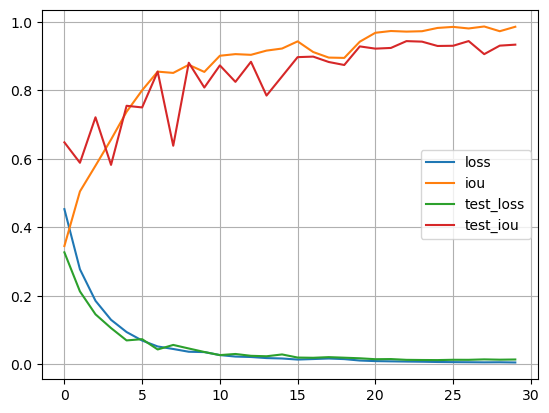

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

In [20]:
import matplotlib.colors as mcolors

classes = ['50bs', '20bs', '10bs', 'background']
colors = ['#1f77b4', '#ff9e80', '#8bc34a', '#9e9e9e'] # Colores fijos para cada clase

def plot_predict(img, mask, model):
    model.eval().to(device)
    with torch.no_grad():
        img = img.to(device)
        mask = mask.to(device)

        output = model(img)[0]
        pred_mask = torch.argmax(output, dim=0)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    ax1.set_title('Imagen', fontsize=25)
    ax1.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    ax2.set_title('Máscara', fontsize=25)
    ax2.imshow(mask.squeeze().cpu().numpy())

    ax3.set_title('Predicción', fontsize=25)
    ax3.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    # Asignar colores fijos a cada canal en la pred_mask (one-hot encoding)
    colored_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
    for i in range(len(classes)):
        colored_mask[pred_mask.cpu() == i] = np.array(mcolors.to_rgba(colors[i], 1)[:3]) * 255  #type: ignore Obtener RGB de los colores fijos y escalar a [0, 255]

    ax3.imshow(colored_mask, alpha=0.8)

    # Crear una leyenda personalizada con colores fijos para cada clase
    legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[i], markersize=10, label=classes[i]) for i in range(len(classes))] # type: ignore

    # Agregar leyenda al tercer subplot
    ax3.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), bbox_transform=ax3.transAxes, fontsize=20)

    plt.show()

99


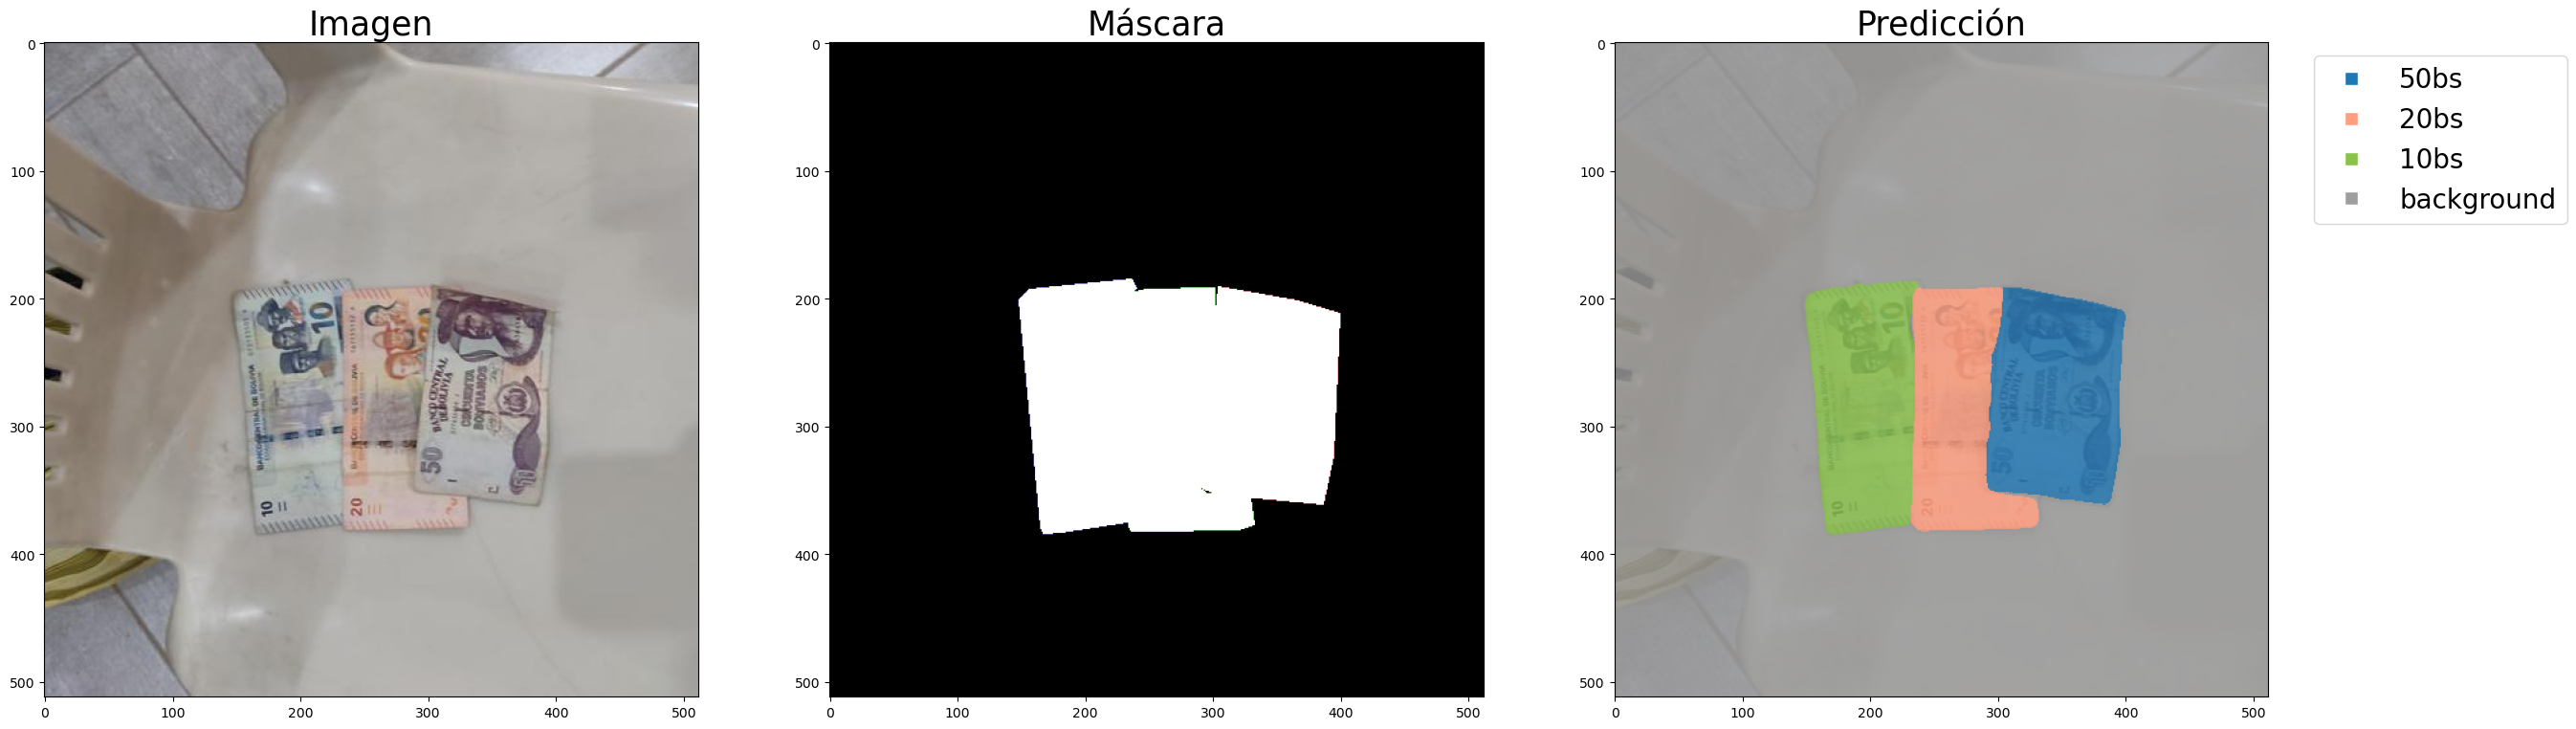

In [26]:
import random

ix = random.randint(0, len(dataset['test']) - 1)
#ix = 99
print(ix)
img, mask = dataset['test'][ix]
img = img.clone().detach().unsqueeze(0).to(device).float()
mask = mask.clone().detach().permute(1, 2, 0)

plot_predict(img, mask, model)

## Resultados

Precisión de Yolov8: 